# Проект: Статистический анализ данных

В настоящем проекте мы исследуем данные мобильного приложения сервиса аренды самокатов GoFast.

Целями этого исследования является изучение потребительсткого поведения клиентов в зависимости от выбранного ими тарифного плана, а также понимание коммерческой эффективности от оказания услуг этим категориям клиентов.

Объектами исследования являются следующие данные:
- база данных о пользователях сервиса
- справочних тарифных планов
- записи о совершенных поездках пользователей сервиса

В процессе подготовки к исследованию мы проведем предобработку данных, в процессе которой выполним следующие работы:
- загрузка данных в формате CSV
- проверка и устранение явных дубликатов в записях
- проверка наличия пропусков в данных и их устранение
- приведем данные к правильным форматам
- добавим информацию о порядковом номере месяца поездки

Далее мы проведем исследовательский анализ и визуализируем данные в следующих разрезах:
- частота встречаемости городов
- соотношение пользователей с подпиской и без подписки
- возраст пользователей
- расстояние, которое пользователь преодолел за одну поездку
- продолжительность поездок

После этого произведем подсчет выручки, которая должна была быть получена согласно находящейся в нашем распоряжении телеметрии о поездках. Для этого выполним следующие действия с данными:
1. Объединим все данные в одну таблицу
2. Разделим полученную таблицу на две:
    - данные пользователей с подпиской
    - данные пользователей на свободном тарифном плане
3. Вычислим суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
4. Вычислим суммарную выручку, которую принес каждый пользователь за месяц, с учетом его тарифного плана

Для полученной информации мы сформулируем следующие гипотезы и проверим их методами статистического анализа:
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Дополнительно, мы проведем следующие исследования:
1. Какое минимальное количество промокодов нужно разослать в процессе маркетинговой акции, чтобы с заданной вероятностью подписку продлили запланированное количество пользователей.
2. Оценить вероятность прочтения push-уведомлений о маркетинговых акциях заданным количеством пользователей мобильного приложения.

#### Шаг 1. Загрузка данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

In [2]:
#загрузим данные о пользователях
users = pd.read_csv('/datasets/users_go.csv')
#изучим полученные данные
display(users.head())
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пропусков в данных нет, типы данных в норме

In [3]:
#загрузим данные о поездках
rides = pd.read_csv('/datasets/rides_go.csv')
#изучим полученные данные
display(rides.head())
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Пропусков в данных нет, типы данных нужно преобразовать следующим образом:
1. distance - привести к целому типу, поскольку они измеряются в метрах и большая точность нам неинтересна
2. date - привести к формату даты pandas

In [4]:
#загрузим данные о подписках
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
#изучим полученные данные
display(subscriptions)
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Справочник подписок в порядке

#### Шаг 2. Предобработка данных

In [5]:
#приведем выбранные данные датафрейма rides к целому типу
rides['distance'] = rides['distance'].astype('int32')

In [6]:
#Приведем столбец date датафрейма rides к типу даты pandas.
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [7]:
#проверим результат
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int32         
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 494.2 KB


In [8]:
#перед назначением номера месяца проверим, что у нас имеются данные только за один год 
period_check = pd.DataFrame(rides['date'])
period_check['year'] = pd.DatetimeIndex(period_check['date']).year
period_check['year'].unique()

array([2021])

In [9]:
#Создадим новый столбец с номером месяца для даты
rides['month'] = pd.DatetimeIndex(rides['date']).month

In [10]:
#проверим наличие дубликатов в данных
print('Дубликатов в таблице users:', users.duplicated().sum())
print('Дубликатов в таблице rides:', rides.duplicated().sum())

Дубликатов в таблице users: 31
Дубликатов в таблице rides: 0


In [11]:
#устраним дубликаты в таблице users и проверим результат
users = users.drop_duplicates()
print('Дубликатов в таблице users:', users.duplicated().sum())

Дубликатов в таблице users: 0


В таблице есть потенциальные неявные дубликаты в именах Наталья/Наталия/Наташа, но поскольку каждый пользователь снабжен уникальным идентификатором, и у нас нет других достоверных данных, чтобы утверждать о наличии дубликата - оставим эти записи без изменения.

In [12]:
#проверим наличие пропусков
print('Пропусков в таблице users:')
print(users.isna().sum())
print()
print('Пропусков в таблице rides:')
print(rides.isna().sum())

Пропусков в таблице users:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропусков в таблице rides:
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


**Вывод по этапу предобработки данных**

Имеющиеся в наличии данные в хорошем состоянии, пропусков значений не обнаружено, явные дубликаты зафиксированы только в таблице users. Проведены следующие работы:
1. поле distance таблицы rides приведено к целому типу, поскольку они измеряются в метрах и большая точность нам неинтересна
2. поле date таблицы rides приведено к формату даты pandas
3. в таблицу rides добавлен столбец с информацией о месяце поездки, для целей дальнейшего анализа
4. устранены явные дубликаты в таблице users в количестве 31 штуки

#### Шаг 3. Исследовательский анализ данных

**Частота встречаемости городов**

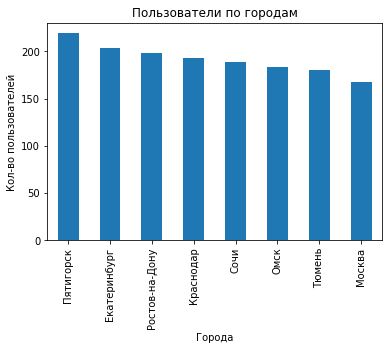

In [13]:
#построим гистограмму по количеству пользователей в городах
users['city'].value_counts().plot(kind='bar')
plt.title('Пользователи по городам')
plt.xlabel('Города')
plt.ylabel('Кол-во пользователей')
plt.show()

In [14]:
#также проведем количественный анализ
users['city'].value_counts().sort_values(ascending=False)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

**Вывод**

Количество клиентов по городам распределено достаточно равномерно. 

При этом можно сказать, что в Пятигорске GoFast удалось получить большую долю рынка, чем в Москве.

**Соотношение пользователей с подпиской и без подписки**

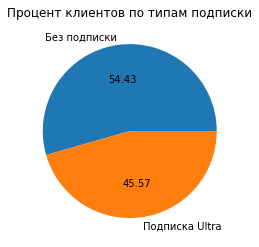

In [15]:
#построим график в виде круговой диаграммы
plt.pie(users['subscription_type'].value_counts(), labels=['Без подписки', 'Подписка Ultra'], autopct='%.2f')
plt.title('Процент клиентов по типам подписки')
plt.show()

In [16]:
print('Доля пользователей с подпиской - {:.0%}'.format(len(users.query('subscription_type == "ultra"')) / len(users)))
print('Доля разовых клиентов - {:.0%}'.format(len(users.query('subscription_type == "free"')) / len(users)))

Доля пользователей с подпиской - 46%
Доля разовых клиентов - 54%


Пользователей с бесплатным тарифом ожидаемо больше, но тем не менее почти половина пользователей приобрели подписку. Это говорит о том, что тарифный план подписки Ultra оценивается пользователями как выгодный.

**Возраст пользователей**

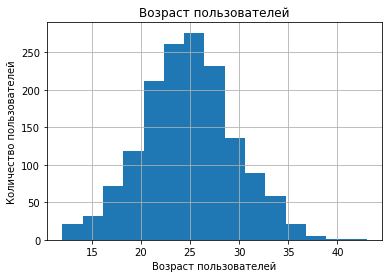

In [17]:
users['age'].hist(bins=15)
plt.title('Возраст пользователей')
plt.xlabel('Возраст пользователей')
plt.ylabel('Количество пользователей')
plt.show()

In [18]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Пользователи по возрасту распределены нормально, большая часть пользователей в возрасте около 25 лет. Выбросы за пределами полуторных межквартальных отклонений отсутствуют.

Это говорит о том, что данные о возрасте пользователей можно считать достоверными.

**Расстояние, которое пользователь преодолел за одну поездку**

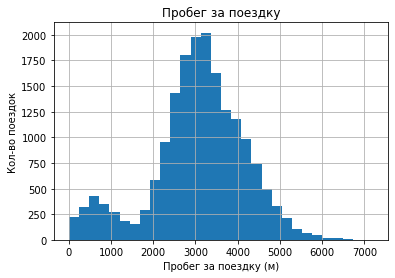

In [19]:
rides['distance'].hist(bins=30)
plt.title('Пробег за поездку')
plt.xlabel('Пробег за поездку (м)')
plt.ylabel('Кол-во поездок')
plt.show()

Информация о типовом пробеге за одну поездку также показывает близкое к нормальному распределение в двух группах поездок:
- до 1500 метров
- свыше 1500 метров

Наблюдается всплеск в диапазоне от 3100 до 3200 метров, причина которого на данный момент непонятна.

Также мы видим набор данных о поездках с крайне низкой длительностью - проанализируем их подробнее.

In [20]:
rides.query('distance < 20')

,user_id,distance,duration,date,month
7841,796,7,10.026614,2021-11-26,11
8324,835,12,4.034952,2021-09-19,9
8658,861,6,6.015656,2021-07-21,7
8906,880,11,2.035632,2021-03-28,3
9541,925,2,3.011018,2021-10-19,10
11555,1069,0,10.001902,2021-01-31,1
11862,1091,15,13.044660,2021-03-29,3
13690,1223,4,4.008958,2021-05-22,5
13940,1240,15,10.045002,2021-08-20,8
15626,1364,15,6.057623,2021-08-22,8


Данные выглядят в целом естесственно - пользователь мог передумать ехать, или ему не понравился самокат и он решил сменить его на первых минутах поездки.

Оставим эти данные в наборе.

**Изучим причины наличия двух групп поездок с разной средней длительностью.**

Можно сделать следующие предположения:
* разница потребительского поведения в выходные и рабочие дни
* сезонность
* месторасположениями пунктов раздачи самокатов в разных городах.
* возраст пользователей

Проверим гипотезу о выходных днях

In [21]:
rides_test = rides

In [22]:
rides_test['weekday'] = pd.DatetimeIndex(rides_test['date']).weekday

In [23]:
def mark_weekend(row):
    if row['weekday'] in range(0, 5):
        return 'Рабочий день'
    else:
        return 'Выходной'

rides_test['day_type'] = rides_test.apply(mark_weekend, axis=1)     

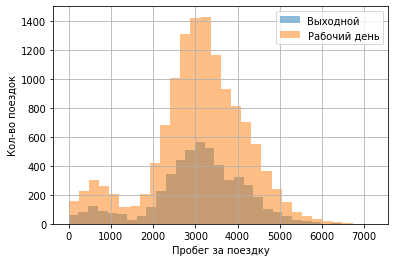

In [24]:
rides_test.groupby('day_type')['distance'].hist(bins=30, alpha=0.5, legend=True)
plt.xlabel('Пробег за поездку')
plt.ylabel('Кол-во поездок')
plt.show()

Распределение поездок в выходные и рабочие дни имеет одинаковые параметры распределения - значит причина не в этом.

Проверим гипотезу о сезонности:

In [25]:
def mark_season(row):
    if row['month'] in [12, 1, 2]:
        return 'Зима'
    elif row['month'] in [3, 4, 5]:
        return 'Весна'
    elif row['month'] in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

rides_test['season'] = rides_test.apply(mark_season, axis=1)

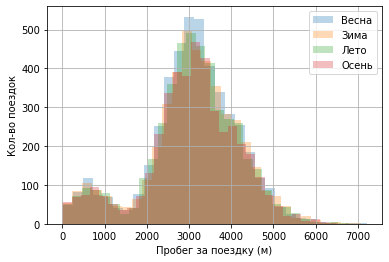

In [26]:
rides_test.groupby('season')['distance'].hist(bins=30, alpha=0.3, legend="True")
plt.xlabel('Пробег за поездку (м)')
plt.ylabel('Кол-во поездок')
plt.show()

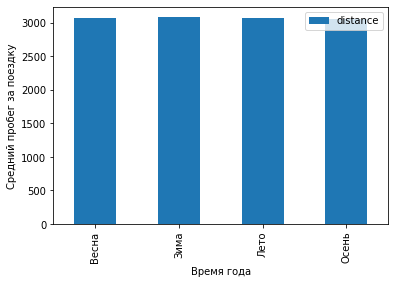

In [27]:
rides_test.pivot_table(index='season', values='distance').plot(kind='bar')
plt.xlabel('Время года')
plt.ylabel('Средний пробег за поездку')
plt.show()

Средний пробег по сезонам не различается, и распределения аналогично имеют два пика.

Проверим города:

In [28]:
#добавим в таблицу поездок характеристики пользователей
rides_test = rides_test.merge(users, on='user_id')
rides_test.head()

,user_id,distance,duration,date,month,weekday,day_type,season,name,age,city,subscription_type
0,1,4409,25.599769,2021-01-01,1,4,Рабочий день,Зима,Кира,22,Тюмень,ultra
1,1,2617,15.816871,2021-01-18,1,0,Рабочий день,Зима,Кира,22,Тюмень,ultra
2,1,754,6.232113,2021-04-20,4,1,Рабочий день,Весна,Кира,22,Тюмень,ultra
3,1,2694,18.511000,2021-08-11,8,2,Рабочий день,Лето,Кира,22,Тюмень,ultra
4,1,4028,26.265803,2021-08-28,8,5,Выходной,Лето,Кира,22,Тюмень,ultra


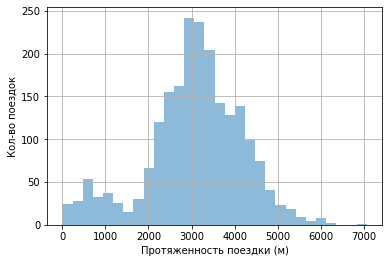

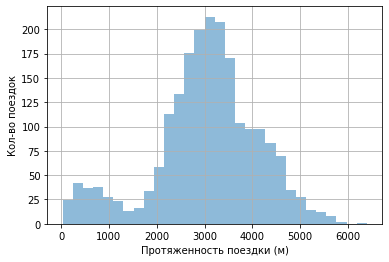

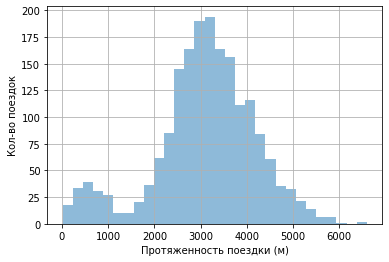

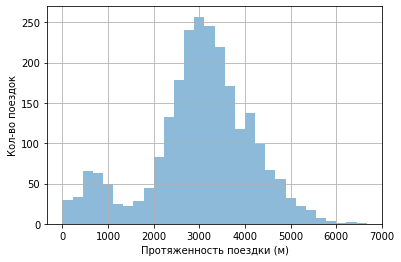

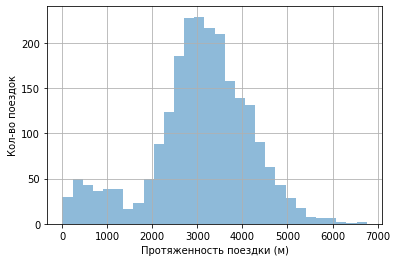

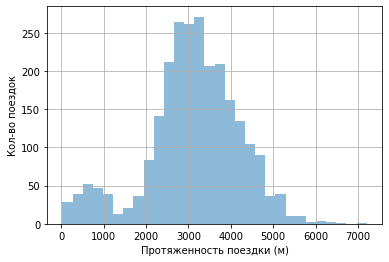

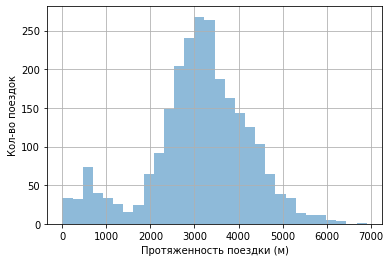

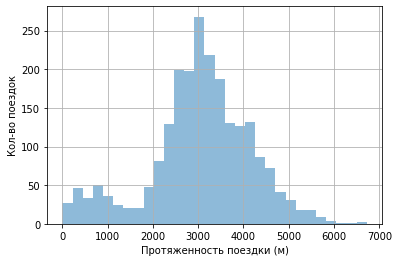

In [29]:
for city in users['city'].unique():
    rides_test.query('city == @city')['distance'].hist(bins=30, alpha=0.5)
    plt.xlabel('Протяженность поездки (м)')
    plt.ylabel('Кол-во поездок')
    plt.show()

Во всех городах картина одинаковая.

Проверим возраст пользователей:

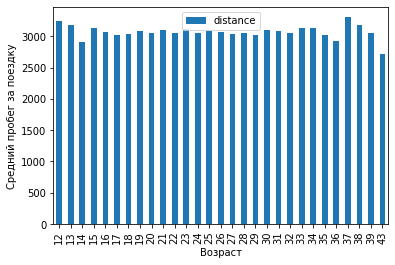

In [30]:
rides_test.pivot_table(index='age', values='distance').plot(kind='bar')
plt.xlabel('Возраст')
plt.ylabel('Средний пробег за поездку')
plt.show()

Анализ среднего пробега по возрасту клиентов также показывает отсутствие корреляции с короткими поездками.

Таким образом, мы отвергли все гипотезы, которые можно было поставить по имеющимся данным.

Это позволяет сделать вывод, что наличие этих распределений не вызвано какими-то объективными причинами.

Соответственно, для выяснения этих причин следует проконсультироваться по процессу оказания услуги и техническим параметрам оорудования.

**Продолжительность поездок**

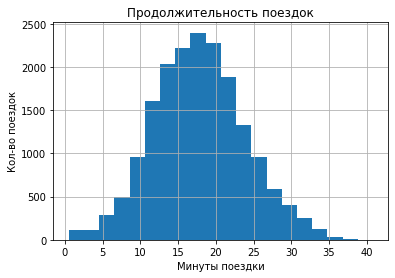

In [31]:
rides['duration'].hist(bins=20)
plt.title('Продолжительность поездок')
plt.xlabel('Минуты поездки')
plt.ylabel('Кол-во поездок')
plt.show()

Продолжительность поездок распределена нормально, с типовым значением в районе 18 минут.

Также мы можем наблюдать набор значений с близкой к нулю продолжительностью поездки.

Изучим зависимость пройденного расстояния от длительности поездки:

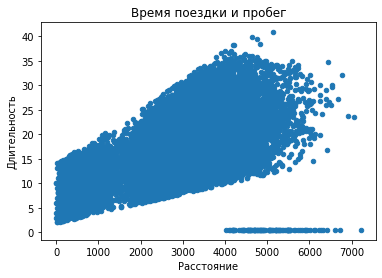

In [32]:
rides.plot(x='distance', y='duration', kind='scatter')
plt.title('Время поездки и пробег')
plt.xlabel('Расстояние')
plt.ylabel('Длительность')
plt.show()

Диаграмма показывает наличие ожидаемой прямой зависимости длительности поездки от расстояния, а также диапазон типовых скоростей, с которыми движутся клиенты.

Как мы можем видеть на этом графике, данные содержат набор записей с близкой к нулю длительностью и пробегом свыше 4 км за сессию. Судя по всему, такие данные вызваны какой-то технической ошибкой, поэтому исключим их из набора данных и направим информацию об этих сессиях уполномоченным сотрудникам.

In [33]:
#уточним значение длительности поездки для этих записей
rides['duration'].min()

0.5

In [34]:
#проверим количество этих записей на соответствие норме очистки
len(rides.query('duration == 0.5')) / len(rides)

0.005257914545052026

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
Если это и была акция, то она явно не удалась))
</div>

In [35]:
#уберем эти данные из набора
rides = rides[rides['duration'] != 0.5]

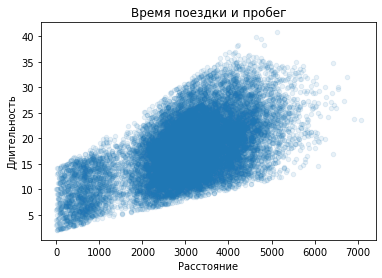

In [36]:
#Проверим результат
rides.plot(x='distance', y='duration', kind='scatter', alpha=0.1)
plt.title('Время поездки и пробег')
plt.xlabel('Расстояние')
plt.ylabel('Длительность')
plt.show()

На этой диаграмме мы также можем наблюдать разделение поездок на группы до и свыше 1500 метров. Можно сделать предположение, что это группы клиентов, которые пользуются самокатами для развлечения и как средство транспорта.

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм:

In [37]:
data = users.merge(rides, on='user_id')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,day_type,season
0,1,Кира,22,Тюмень,ultra,4409,25.599769,2021-01-01,1,4,Рабочий день,Зима
1,1,Кира,22,Тюмень,ultra,2617,15.816871,2021-01-18,1,0,Рабочий день,Зима
2,1,Кира,22,Тюмень,ultra,754,6.232113,2021-04-20,4,1,Рабочий день,Весна
3,1,Кира,22,Тюмень,ultra,2694,18.511000,2021-08-11,8,2,Рабочий день,Лето
4,1,Кира,22,Тюмень,ultra,4028,26.265803,2021-08-28,8,5,Выходной,Лето


In [38]:
data = data.merge(subscriptions, on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,day_type,season,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409,25.599769,2021-01-01,1,4,Рабочий день,Зима,6,0,199
1,1,Кира,22,Тюмень,ultra,2617,15.816871,2021-01-18,1,0,Рабочий день,Зима,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6.232113,2021-04-20,4,1,Рабочий день,Весна,6,0,199
3,1,Кира,22,Тюмень,ultra,2694,18.511000,2021-08-11,8,2,Рабочий день,Лето,6,0,199
4,1,Кира,22,Тюмень,ultra,4028,26.265803,2021-08-28,8,5,Выходной,Лето,6,0,199


In [39]:
#проверим корректность данных после объединения
len(data) - len(rides)

0

In [40]:
display(data.shape)
rides.shape

(17973, 15)

(17973, 8)

Разделим полученную таблицу на две:
* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

In [41]:
data_ultra = data.query('subscription_type == "ultra"')
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,day_type,season,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409,25.599769,2021-01-01,1,4,Рабочий день,Зима,6,0,199
1,1,Кира,22,Тюмень,ultra,2617,15.816871,2021-01-18,1,0,Рабочий день,Зима,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6.232113,2021-04-20,4,1,Рабочий день,Весна,6,0,199
3,1,Кира,22,Тюмень,ultra,2694,18.511000,2021-08-11,8,2,Рабочий день,Лето,6,0,199
4,1,Кира,22,Тюмень,ultra,4028,26.265803,2021-08-28,8,5,Выходной,Лето,6,0,199


In [42]:
data_free = data.query('subscription_type == "free"')
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,day_type,season,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515,14.944286,2021-01-02,1,5,Выходной,Зима,8,50,0
6501,700,Айдар,22,Омск,free,846,16.234663,2021-02-01,2,0,Рабочий день,Зима,8,50,0
6502,700,Айдар,22,Омск,free,4004,20.016628,2021-02-04,2,3,Рабочий день,Зима,8,50,0
6503,700,Айдар,22,Омск,free,1205,9.782872,2021-02-10,2,2,Рабочий день,Зима,8,50,0
6504,700,Айдар,22,Омск,free,3047,17.427673,2021-02-14,2,6,Выходной,Зима,8,50,0


In [43]:
#убедимся что мы разпределили данные полностью
len(data) - len(data_ultra) - len(data_free)

0

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

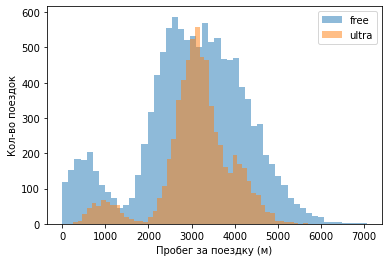

In [44]:
diagram = data.groupby('subscription_type')['distance']
diagram.plot(kind='hist', bins=50, alpha=0.5, legend=True)
plt.xlabel('Пробег за поездку (м)')
plt.ylabel('Кол-во поездок')
plt.show()

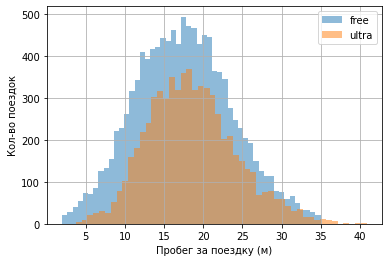

In [45]:
data.groupby('subscription_type')['duration'].hist(bins=50, alpha=0.5, legend=True)
plt.xlabel('Пробег за поездку (м)')
plt.ylabel('Кол-во поездок')
plt.show()

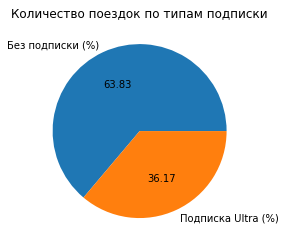

In [46]:
plt.pie(data.groupby('subscription_type')['duration'].count(), labels=['Без подписки (%)', 'Подписка Ultra (%)'], autopct='%.2f')
plt.title('Количество поездок по типам подписки')
plt.show()

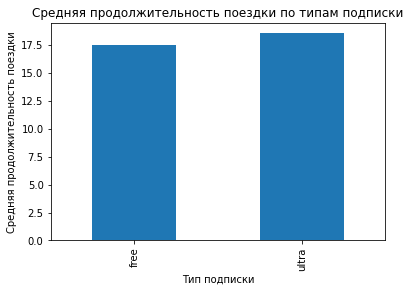

In [47]:
data.groupby('subscription_type')['duration'].mean().plot(kind='bar')
plt.title('Средняя продолжительность поездки по типам подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Средняя продолжительность поездки')
plt.show()

**Наблюдения**
При раздельном анализе данных по пользователям с разными типами подписки мы видим, что распределение расстояния поездок у пользователей с подпиской имеет меньшую величину стандартного отклонения.

Распределение же пробега в одной поездке разовых клиентов, напротив, имеет гораздо больший разброс, даже в области среднего значения, где мы видим два пика на метках примерно 2,5 и 3,5 километра.

Таким образом можно предположить, что подписчики сервиса ездят в основном по одинаковым для себя маршрутам, в то время как разнообразие маршрутов разовых клиентов гораздо шире.

При этом распределение длительности поездок демонстрирует схожую картину у пользователей с разными типами подписки, что вкупе с сильным разбросом пробега за поездку говорит о том, что средняя скорость у клиентов на бесплатном плане также сильно вирьируется.

Количество поездок пользователей без подписки почти вдвое превышает количество поездок подписчиков. При этом мы помним, что количество клиентов с подпиской и без почти одинаково, с преимуществом в районе 8% у пользователей без подписки. Это говорит о том, что разовые пользователи совершают больше поездок.

В то же время, продолжительность поездок у пользователей с подпиской и без примерно одинакова.

В итоге видим парадоксальную ситуацию, когда поведение пользователей без подписки обратно пропорционально их финансовым интересам.

**Выводы**
На основе этих наблюдений можно сделать вывод о том, что клиенты с подпиской являются более опытными пользователями сервиса, поскольку демонстрируют большую уверенность в езде, используют самокат как основное средство транспорта, и коммерческая эффективность имеет для них значение, поскольку склонность к сокращению количества стартов у них судя по всему унаследована от периода пользования сервисом на свободном плане.

В свою очередь, для пользователей на свободном плане затраты на поездки практически не имеют значения, и они не пользуются подпиской даже при очевидности ее выгоды. Это делает пользователей без подписки более выгодными клиентами для сервиса, и следует более подробно изучить их характеристики для продвижения информации о компании среди этих категорий клиентов.

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными и вычислим следующие показатели для каждого пользователя за каждый месяц:
* суммарное расстояние
* количество поездок
* суммарное время

In [48]:
#создадим новую таблицу с нужными данными
rides_data = data.loc[:,['user_id', 'distance', 'duration', 'month', 'subscription_type', 'subscription_fee']]
#добавим в нее счетчик записей
rides_data['count'] = 1
#для длительности поездки предварительно округлим до большего в соответствии с правилами тарификации
rides_data['duration'] = np.ceil(rides_data['duration']).astype('int32')
#построим сводную таблицу, оформим ее и выведем на экран
rides_pivot = rides_data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration', 'count'], aggfunc='sum')
rides_pivot.columns = ['Кол-во поездок', 'Общее расстояние', 'Общая длительность']
rides_pivot

Кол-во поездок  Общее расстояние  Общая длительность
user_id month                                                      
1       1                   2              7026                  42
        4                   1               754                   7
        8                   2              6722                  46
        10                  2              5809                  32
        11                  3              7002                  56
...                       ...               ...                 ...
1534    6                   2              3409                  26
        8                   2              7621                  48
        9                   1              4928                  23
        11                  4             13349                  78
        12                  1              2371                  16

[11300 rows x 3 columns]

Рассчитаем в новой таблице выручку, которую принёс каждый пользователь.
Для этого добавим в новую таблицу поездок информацию о тарифном плане пользователя, а затем рассчитаем на его основании стоимость каждой поездки.

In [49]:
#функция для расчета выручки
def calc_revenue (ride):
    plan = ride['subscription_type']
    if plan == 'free':
        return ride['duration'] * 8 + 50
    else:
        return ride['duration'] * 6

#применим функцию к таблице для расчета выручки
rides_data['revenue'] = rides_data.apply(calc_revenue, axis=1)

In [50]:
#рассчитаем итоговую суммарную помесячную выручку от поездок в сводной таблице 
rides_revenue = rides_data.pivot_table(index=['user_id', 'month'], values='revenue', aggfunc='sum')
rides_revenue.columns = ['Оплата поездок']
rides_revenue.head(10)

Оплата поездок
user_id month                
1       1                 252
        4                  42
        8                 276
        10                192
        11                336
        12                168
2       3                 378
        4                 240
        6                  84
        7                 288

In [51]:
#построим сводную таблицу для стоимости подписки 
monthly_fee = rides_data.pivot_table(index=['user_id', 'month'], values=['subscription_type', 'subscription_fee'], aggfunc='first')
monthly_fee.columns = ['Стоимость подписки', 'Тарифный план']
monthly_fee

Стоимость подписки Тарифный план
user_id month                                  
1       1                     199         ultra
        4                     199         ultra
        8                     199         ultra
        10                    199         ultra
        11                    199         ultra
...                           ...           ...
1534    6                       0          free
        8                       0          free
        9                       0          free
        11                      0          free
        12                      0          free

[11300 rows x 2 columns]

In [52]:
#добавим к таблице стоимости поездок столбец со стоимостью подписок 
total_revenue = rides_revenue.join(monthly_fee)
total_revenue

Оплата поездок  Стоимость подписки Тарифный план
user_id month                                                  
1       1                 252                 199         ultra
        4                  42                 199         ultra
        8                 276                 199         ultra
        10                192                 199         ultra
        11                336                 199         ultra
...                       ...                 ...           ...
1534    6                 308                   0          free
        8                 484                   0          free
        9                 234                   0          free
        11                824                   0          free
        12                178                   0          free

[11300 rows x 3 columns]

In [53]:
#Вычислим общую выручку за месяц
total_revenue['Итого за месяц'] = total_revenue['Оплата поездок'] + total_revenue['Стоимость подписки']
total_revenue

Оплата поездок  Стоимость подписки Тарифный план  \
user_id month                                                     
1       1                 252                 199         ultra   
        4                  42                 199         ultra   
        8                 276                 199         ultra   
        10                192                 199         ultra   
        11                336                 199         ultra   
...                       ...                 ...           ...   
1534    6                 308                   0          free   
        8                 484                   0          free   
        9                 234                   0          free   
        11                824                   0          free   
        12                178                   0          free   

               Итого за месяц  
user_id month                  
1       1                 451  
        4                 241  
        8                 475  
        10                391  
        11                535  
...                       ...  
1534    6                 308  
        8                 484  
        9                 234  
        11                824  
        12                178  

[11300 rows x 4 columns]

#### Шаг 6. Проверка гипотез

**Гипотеза 1**

Тратят ли пользователи с подпиской больше времени на поездки?

Сформулируем гипотезы:
* нулевая - равенство средней величины длительности поездки у подписчиков и пользователей без подписки
* альтернативная - средняя длительность поездок у подписчиков выше длительности поездок пользователей без подписки
Проверим гипотезы при помощи T-теста для двух независимых выборок.

In [54]:
#рассчитаем реальное среднее продолжительности поездки по двум выборбкам
duration_ultra = data_ultra['duration']
duration_free = data_free['duration']
print('Средняя продолжительность поездки у подписчиков:', np.ceil(np.mean(duration_ultra)), 'минут')
print('Средняя продолжительность поездки у разовых клиентов:', np.ceil(np.mean(duration_free)), 'минут')

Средняя продолжительность поездки у подписчиков: 19.0 минут
Средняя продолжительность поездки у разовых клиентов: 18.0 минут


In [55]:
#установим порог значимости как 5%
alpha = 0.05
#проверим нулевую гипотезу при помощи T-теста 
result = st.ttest_ind(duration_ultra, duration_free, alternative='greater')
if result.pvalue < alpha:
    print('p-value =', result.pvalue)
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('p-value =', result.pvalue)
    print('Нулевая гипотеза не отвергается')

p-value = 4.704468074453899e-28
Отвергаем нулевую гипотезу в пользу альтернативной


**Вывод**

Опровержение нулевой гипотезы означает, что продолжительность поездок подписчиков с высокой вероятностью будет выше средней длительности поездок разовых клиентов. Это позволяет сделать предварительный вывод о том, что пользователи с подпиской могут приносить больше выручки за одну поездку при одинаковом тарифе. Однако, тариф для подписчиков у нас отличается от стоимости разовой поездки, и в данном анализе мы не учитывали количество поздок. Поэтому, для формулировки окончательного вывода о "выгодности" клиентов по типам подписки требуется провести дополнительные исследования.

**Гипотеза 2**

Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает
3130 метров?

Сформулируем гипотезы:
* нулевая - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров
* альтернативная - средняя длительность поездок у подписчиков больше 3130 метров

Таким образом, если мы не сможем опровергнуть нулевую гипотезу, это будет означать, что вероятность получить пробег выше 3130 метров крайне низка, и основная масса поездок будет укладываться в это расстояние.

Проверим эти гипотезы при помощи T-теста для одной выборки:

In [56]:
#установим порог значимости как 5%
alpha = 0.05
#проверим нулевую гипотезу при помощи T-теста
ultra_rides = data.query('subscription_type == "ultra"')['distance']
result = st.ttest_1samp(ultra_rides, 3130, alternative='greater')
if result.pvalue < alpha:
    print('p-value =', result.pvalue)
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('p-value =', result.pvalue)
    print('Нулевая гипотеза не отвергается')

p-value = 0.9264356652998772
Нулевая гипотеза не отвергается


**Вывод**

Согласно показаниям T-теста, мы с высокой вероятностью можем утверждать, что пользователи с подпиской не проезжают за одну поездку больше 3130 метров.

**Гипотеза 3**

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Сформулируем гипотезы:
* нулевая - помесячные выручки от пользователей с подпиской и без равны между собой
* альтернативная - помесячная выручка от пользователей с подпиской выше

Для проверки этой гипотезы проведем правосторонний Т-тест на двух независимых выборках из таблицы с расчетом помесячной выручки.

In [57]:
#сформируем выборки
subscribers_revenue = total_revenue[total_revenue['Тарифный план'] == 'ultra']['Итого за месяц']
freeplan_revenue = total_revenue[total_revenue['Тарифный план'] == 'free']['Итого за месяц']

In [58]:
#установим минимальный порог значимости
alpha = 0.01
#проверим нулевую гипотезу при помощи T-теста 
result = st.ttest_ind(subscribers_revenue, freeplan_revenue, alternative='greater')
if result.pvalue < alpha:
    print('p-value =', result.pvalue)
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('p-value =', result.pvalue)
    print('Нулевая гипотеза не отвергается')

p-value = 2.0314113674863288e-30
Отвергаем нулевую гипотезу в пользу альтернативной


**Вывод**

Статистический анализ показывает, что помесячная выручка подписчиков с высокой вероятностью будет выше ежемесячной выручки разовых клиентов.

**Динамика обращений в техподдержку**

Для проверки гипотезы в описанной в задании ситуации, нам потребуется провести Т-тест для двух зависимых выборок - scipy.stats.ttest_rel.

#### Шаг 7. Распределения

**Акция с промокодами**

***Цель акции*** - как минимум 100 существующих клиентов должны продлить эту подписку

***Вероятность успеха*** - после бесплатного пробного периода подписку обычно продлевают 10 % пользователей

***Задача*** - выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Для решения этой задачи построим биномиальное распределение со следующими параметрами:
* количество экспериментов - переменная величина
* вероятность успеха - 10%

Затем вычислим для этого распределения кумулятивную функцию распределения.
Используя кумулятивную функцию, определим, сколько отправок надо сделать, чтобы с вероятностью более 95% получить желаемый результат.
После этого вычислим необходимый объем рассылки умножив целевое количество продлений на количество отправок.

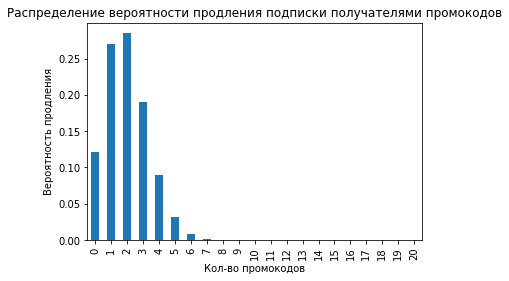

In [59]:
#зададим параметры распределения
n = 20
p = 0.1
#создадим объект Series для распределения и заполним его данными
distr = pd.Series(dtype='float32', index=[0])
for k in range(0, n + 1):
    distr[k] = binom.pmf(k, n, p)
#отобразим распределение на графике
distr.plot(xlabel='Кол-во промокодов', ylabel='Вероятность продления', kind='bar')
plt.title('Распределение вероятности продления подписки получателями промокодов')
plt.show()

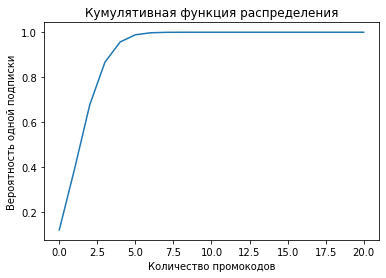

In [60]:
#построим кумулятивную функцию для этого распределения
cdf = pd.Series(dtype='float32', index=[0])
cdf[0] = distr[0]
for pos in distr.index[1:]:
    cdf[pos] = cdf[(pos-1)] + distr[pos]
            
cdf.plot(xlabel='Количество промокодов', ylabel='Вероятность одной подписки')
plt.title('Кумулятивная функция распределения')
plt.show()

In [61]:
#вычислим сколько отправок надо сделать для достижения результата с вероятностью 95% и более
attempts = cdf.index[cdf >= 0.95].min()
#вычислим целевой объем рассылки промокодов
print('Для выполнения плана по подпискам с вероятностью 95% надо разослать минимум', attempts*100, 'промокодов')

Для выполнения плана по подпискам с вероятностью 95% надо разослать минимум 400 промокодов


In [62]:
#код согласно рекомендации
p=0.1
k=100

for n in range(1, 1500):
    if (1 - binom.cdf(k,n,p)) > 0.05:
        print ('Для выполнения плана по подпискам с вероятностью 95% надо разослать минимум', n, 'промокодов')
        break

Для выполнения плана по подпискам с вероятностью 95% надо разослать минимум 859 промокодов


In [63]:
# Код ревьюера

target_clients = 100  # Целевое количество клиентов для продления подписки
p_renewal = 0.1       # Вероятность продления подписки

# Подбор значения параметра n
n = 1
while binom.cdf(target_clients - 1, n, p_renewal) > 0.05:
    n += 1

# Вывод 
print(f"Минимальное количество промокодов: {n}")
print(f"Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(target_clients - 1, n, p_renewal):.3%}")

Минимальное количество промокодов: 1161
Вероятность не выполнить план при таком количестве промокодов: 4.976%


In [64]:
#код согласно рекомендации
p=0.1
k=100

for n in range(1, 1500):
    if binom.cdf(k,n,p) < 0.05:
        print ('Для выполнения плана по подпискам с вероятностью 95% надо разослать минимум', n, 'промокодов')
        print (f'Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(k,n,p):.3%}')
        break

Для выполнения плана по подпискам с вероятностью 95% надо разослать минимум 1172 промокодов
Вероятность не выполнить план при таком количестве промокодов: 4.955%


**Отправка push-уведомлений**

Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Для решения этой задачи построим нормальное распределение с параметрами:
- n = 1 000 000
- p = 0.4
Затем с помощью метода cdf() вычислим накопленную вероятность искомого значения

In [65]:
#зададим параметры биномиального распределения
n = 1000000
p = 0.4
#вычислим параметры и построим нормальное распределение
mu = n * p
sigma = (n * p * (1 - p))**0.5
distr = st.norm(mu, sigma)
#вычислим вероятность искомого события
result = distr.cdf(399500)
print('Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет {:.2%}'.format(result))

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет 15.37%


**Итоговый вывод** по результатам анализа данных сервиса проката самокатов GoFast.

***Наблюдения***

Состояние данных:
* все данные хорошего качества, без пропусков, формат данных приемлемый
* имеется небольшое количество дубликатов в справочнике пользователей
* данные содержат небольшой набор записей с близкой к нулю длительностью и пробегом свыше 4 км за сессию. Судя по всему, такие данные вызваны какой-то технической ошибкой, с которой следует разобраться

В процессе исследовательского анализа данных мы выявили следующее:
* Количество клиентов по городам распределено достаточно равномерно. При этом можно сказать, что в Пятигорске GoFast удалось получить большую долю рынка, чем в Москве.
* Пользователей с бесплатным тарифом ожидаемо больше, но тем не менее почти половина пользователей приобрели подписку. Это говорит о том, что тарифный план подписки Ultra оценивается пользователями как выгодный.
* Пользователи по возрасту распределены нормально, большая часть пользователей в возрасте около 25 лет. Выбросы за пределами полуторных межквартальных отклонений отсутствуют. Это говорит о том, что данные о возрасте пользователей можно считать достоверными.
* Информация о типовом пробеге за одну поездку также показывает близкое к нормальному распределение в двух группах поездок:
    - до 1500 метров
    - свыше 1500 метров

* Продолжительность поездок распределена нормально, с типовым значением в районе 18 минут.


При раздельном анализе данных по пользователям с разными типами подписки мы наблюдаем следующее:
* Распределение расстояния поездок у пользователей с подпиской имеет меньшую величину стандартного отклонения, чем у разовых клиентов. Это позволяет предположить, что подписчики сервиса ездят в основном по одинаковым для себя маршрутам, в то время как разнообразие маршрутов разовых клиентов гораздо шире.
* Распределение длительности поездок демонстрирует схожую картину у пользователей с разными типами подписки, что вкупе с сильным разбросом пробега за поездку говорит о том, что средняя скорость у клиентов на бесплатном плане также сильно вирьируется.
* Количество поездок пользователей без подписки почти вдвое превышает количество поездок подписчиков. При этом мы помним, что количество клиентов с подпиской и без почти одинаково, с преимуществом в районе 8% у пользователей без подписки. Это говорит о том, что разовые пользователи совершают больше поездок за аналогичный период.
* Продолжительность поездок у пользователей с подпиской и без примерно одинакова.

В процессе проверки гипотез мы обнаружили такие моменты:
* продолжительность поездок подписчиков с высокой вероятностью будет выше средней длительности поездок разовых клиентов
* пользователи с подпиской в среднем проезжают меньше 3130 метров, что соответствует рекомендуемым параметрам эксплуатации оборудования
* помесячная выручка подписчиков с высокой вероятностью будет выше ежемесячной выручки разовых клиентов


**На основе произведенных наблюдений можно сделать следующие выводы:**
1. Несмотря на то, что пользователей без подписки больше по количеству, они совершают больше поездок, демонстрируют экономически иррациональное поведение и приносят в своей совокупности больший объем выручки, статистический анализ показывает, что помесячная выручка подписчиков с высокой вероятностью будет выше ежемесячной выручки разовых клиентов.
2. Таким образом, можно утверждать о том, что пользователи с подпиской являются более выгодными для компании.
3. При этом, способность приносить больше выручки не вызывается самим фактом подписки, поскольку поведение разовых клиентов иррационально, и если их перевести на подписку, то выручка просто уменьшится.

**Рекомендации**

1. Компании следует подробнее изучить потреты пользователей с подпиской, чтобы привлекать больше клиентов из этой целевой аудитории.
2. Активное продвижение подписки среди разовых пользователей сервиса может оказаться вредным, поскольку, при их иррациональном поведении, если они перейдут на подписку, то будут просто меньше платить за пользование сервисом, что может негативно сказаться на общей выручке.
3. При этом, отсутствие продвижения подписки не отпугнет пользователей нашей целевой аудитории, потому что они сами заинтересованы изыскать способ для оптимизации своих затрат.